In [1]:
import sys
sys.path.append('/home/gperri-ext/master_thesis_tryout-2/')

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras, config
from keras import layers
from keras.callbacks import EarlyStopping

physical_devices = config.list_physical_devices('GPU')
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras

from models.windowing_data import multivariate_data, prepare_data
from models.visualization import plot_model_loss, plot_error_metrics, plot_error_metrics_barchart
from models.evaluation_func import timeseries_evaluation_metrics_func, single_timeseries_evaluation_metrics_func, NMAE_error, calculate_evaluation_metrics, evaluate_and_plot_timeseries
from models.temp_features import make_yearly_dataset
from models.daily_errors import calculate_mae_errors, calculate_mape_errors, calculate_rmse_errors, visualize_errors_with_timestamps, filter_errors_at_midnight

2024-02-19 11:25:21.577801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_2179636/405764872.py:30: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


#### Importing data

In [2]:
data_folder = "/home/gperri-ext/master_thesis_tryout-2/data"
file_name = "all_data.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [3]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
# df.drop(['Ora_sin', 'Ora_cos'], axis=1, inplace=True)

In [5]:
df_PUN = df.iloc[:, :3]
df_GAS = df.iloc[:, :5]
df_total_load = df.iloc[:, :7]
df_PUN7 = df.iloc[:,:2]
df_no_tlf = df[['PUN','PUN_d+1-7','GAS', 'GAS_d+1-7','Total_Load_d+1-7', 'Ora', 'holiday']]

#### Preparing data 

In [6]:
dataset_input = make_yearly_dataset(df_no_tlf, 2018, 2020)
# dataset_input = df_PUN7


target_size = 24
past_history = 24*7
train_size = 0.7
test_size = 0.3
step = 1

# Divide il dataset in training, validation e test set
train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

X, y = prepare_data(dataset_input, univariate=False)

X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)

y_norm = y_norm.squeeze()

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                    0, train_index, past_history,
                                    target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                train_index, test_index, past_history,
                                target_size, step=step, single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# shift + tab per sdentare

# y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


X_train shape: (17791, 168, 7)
y_train shape: (17791, 24)
X_test shape: (7267, 168, 7)
y_test shape: (7267, 24)


#### Defining the model

In [32]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer encoder block that consists of a multi-head self-attention mechanism
    followed by a feed-forward neural network.

    Args:
        inputs: Input tensor of shape (batch_size, seq_length, input_dim).
        head_size: Dimensionality of each attention head (for query and keys).
        num_heads: Number of attention heads.
        ff_dim: Dimensionality of the feed-forward neural network.
        dropout: Dropout rate to apply.

    Returns:
        Output tensor of shape (batch_size, seq_length, input_dim).
    """
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x,x) # self attention
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # NN Part, with CONV 1D
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    # x = layers.LSTM(units=ff_dim, return_sequences=True)(x)

    # # Feed Forward Part (Simple feed forward)
    # x = layers.LayerNormalization(epsilon=1e-6)(res)
    # x = layers.Dense(units=ff_dim, activation='relu')(x)
    # x = layers.Dropout(dropout)(x)
    # x = layers.Dense(units=inputs.shape[-1])(x)
    return x + res

#### Prova con decoder

In [33]:
def transformer_decoder(inputs, encoder_output, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer decoder block.

    Args:
        inputs: Input tensor of shape (batch_size, seq_length, input_dim).
        encoder_output: Output tensor from the encoder.
        head_size: Dimensionality of each attention head.
        num_heads: Number of attention heads.
        ff_dim: Dimensionality of the feed-forward neural network.
        dropout: Dropout rate to apply.

    Returns:
        Output tensor of shape (batch_size, seq_length, input_dim).
    """
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, encoder_output)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [34]:
def build_transformer_model(input_shape, target_size, head_size, num_heads, ff_dim, 
                            num_transformer_blocks, mlp_units, mlp_dropout=0.2, dropout=0.25):
    """
    Build a transformer model with encoder and decoder.

    Args:
        input_shape (tuple): The shape of the input tensor.
        target_size (int): The size of the output tensor.
        head_size (int): The size of each attention head.
        num_heads (int): The number of attention heads.
        ff_dim (int): The dimension of the feed-forward layer.
        num_transformer_blocks (int): The number of transformer blocks.
        mlp_units (list): A list of integers specifying the number of units in each MLP layer.
        mlp_dropout (float, optional): The dropout rate for the MLP layers. Defaults to 0.2.
        dropout (float, optional): The dropout rate. Defaults to 0.25.

    Returns:
        keras.Model: The built transformer model.
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Encoder
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Decoder
    decoder_inputs = x  # Output of the encoder becomes input to the decoder
    for _ in range(num_transformer_blocks):
        decoder_inputs = transformer_decoder(decoder_inputs, x, head_size, num_heads, ff_dim, dropout)

    # Final prediction
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(decoder_inputs)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(target_size)(x)

    return keras.Model(inputs, outputs)


In [45]:
# Usage
model = build_transformer_model(
    input_shape=input_shape,
    target_size=target_size,
    head_size=48,
    num_heads=6,
    ff_dim=4,
    num_transformer_blocks=6,
    mlp_units=[128]  # Add the mlp_units argument here
)

In [46]:
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=2e-1,\
    restore_best_weights=True)]

In [47]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
445/445 [==============================] - 110s 116ms/step - loss: 0.1753 - val_loss: 0.0211
Epoch 2/100
445/445 [==============================] - 52s 118ms/step - loss: 0.0422 - val_loss: 0.0148
Epoch 3/100
445/445 [==============================] - 53s 120ms/step - loss: 0.0242 - val_loss: 0.0102
Epoch 4/100
445/445 [==============================] - 54s 121ms/step - loss: 0.0173 - val_loss: 0.0055
Epoch 5/100
445/445 [==============================] - 54s 122ms/step - loss: 0.0139 - val_loss: 0.0059
Epoch 6/100
445/445 [==============================] - 54s 122ms/step - loss: 0.0119 - val_loss: 0.0052


#### Hyperparameters tuner

In [4]:
def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for i in range(hp.Int('num_transformer_blocks', min_value=1, max_value=4, step=1)):
        x = transformer_encoder(x, 
                                 head_size=hp.Int('head_size', min_value=8, max_value=32, step=8),
                                 num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
                                 ff_dim=hp.Int('ff_dim', min_value=4, max_value=16, step=4),
                                 dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)):
        x = layers.Dense(units=hp.Int(f'dense_units_{i}', min_value=64, max_value=512, step=64),
                         activation="relu")(x)
        x = layers.Dropout(rate=hp.Float(f'dense_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = layers.Dense(24)(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')),
        metrics=['mse']
    )
    return model

In [5]:
# Definisci lo spazio degli iperparametri da esplorare
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Numero di combinazioni di iperparametri da provare
    executions_per_trial=1,
    directory='my_dir',
    project_name='forecasting_hyperparameters'
)


INFO:tensorflow:Reloading Tuner from my_dir/forecasting_hyperparameters/tuner0.json


In [6]:
# Cerca gli iperparametri migliori
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Visualizza i risultati della ricerca
tuner.results_summary()

# Ottieni il modello migliore
best_model = tuner.get_best_models(num_models=1)[0]


NameError: name 'X_train' is not defined

#### Only decoder

In [24]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks,
                mlp_units, dropout=0, mlp_dropout=0):
    """
    Build a transformer model.

    Args:
        input_shape (tuple): The shape of the input tensor.
        head_size (int): The size of each attention head.
        num_heads (int): The number of attention heads.
        ff_dim (int): The dimension of the feed-forward layer.
        num_transformer_blocks (int): The number of transformer blocks.
        mlp_units (list): A list of integers specifying the number of units in each MLP layer.
        dropout (float, optional): The dropout rate. Defaults to 0.
        mlp_dropout (float, optional): The dropout rate for the MLP layers. Defaults to 0.

    Returns:
        keras.Model: The built transformer model.
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(target_size)(x)
    return keras.Model(inputs, outputs)

In [25]:
model = build_model(
    input_shape,
    head_size=100, # dimensionality of each attention head, has to be divisible by num_heads (?)
    num_heads=X_train.shape[2],
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.2,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=2e-1,\
    restore_best_weights=True)]


prova con lstm

In [50]:
# def transformer_encoder_lstm(inputs, head_size, num_heads, ff_dim, lstm_units, dropout=0):
#     # Normalization and Attention
#     x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = layers.MultiHeadAttention(
#         key_dim=head_size, num_heads=num_heads, dropout=dropout
#     )(x, x)
#     x = layers.Dropout(dropout)(x)
#     res = x + inputs

#     # LSTM Part
#     x = layers.LayerNormalization(epsilon=1e-6)(res)
#     x = layers.LSTM(lstm_units, return_sequences=True)(x)
#     x = layers.Dropout(dropout)(x)
#     x = layers.LSTM(lstm_units)(x)

#     return x + res

# def build_model_lstm(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks,
#                      lstm_units, mlp_units, dropout=0, mlp_dropout=0):
#     inputs = keras.Input(shape=input_shape)
#     x = inputs
#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder_lstm(x, head_size, num_heads, ff_dim, lstm_units, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#     for dim in mlp_units:
#         x = layers.Dense(dim, activation="relu")(x)
#         x = layers.Dropout(mlp_dropout)(x)
#     outputs = layers.Dense(1)(x)
#     return keras.Model(inputs, outputs)


# input_shape = X_train.shape[1:]

# model = build_model_lstm(
#     input_shape,
#     head_size=24,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     lstm_units=64,  # Imposta il numero di unità LSTM come desiderato
#     mlp_units=[128],
#     mlp_dropout=0.2,
#     dropout=0.25,
# )

# model.compile(
#     loss="mean_squared_error",
#     optimizer=keras.optimizers.Adam(learning_rate=1e-5)
# )

# callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=2e-3, restore_best_weights=True)]




In [26]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=48,
    callbacks=callbacks,
)


Epoch 1/150
297/297 [==============================] - 37s 55ms/step - loss: 0.1052 - val_loss: 0.0087
Epoch 2/150
297/297 [==============================] - 15s 50ms/step - loss: 0.0276 - val_loss: 0.0061
Epoch 3/150
297/297 [==============================] - 15s 52ms/step - loss: 0.0200 - val_loss: 0.0049
Epoch 4/150
297/297 [==============================] - 15s 51ms/step - loss: 0.0155 - val_loss: 0.0041
Epoch 5/150
297/297 [==============================] - 15s 52ms/step - loss: 0.0126 - val_loss: 0.0036
Epoch 6/150
297/297 [==============================] - 16s 55ms/step - loss: 0.0107 - val_loss: 0.0033


### Evaluating

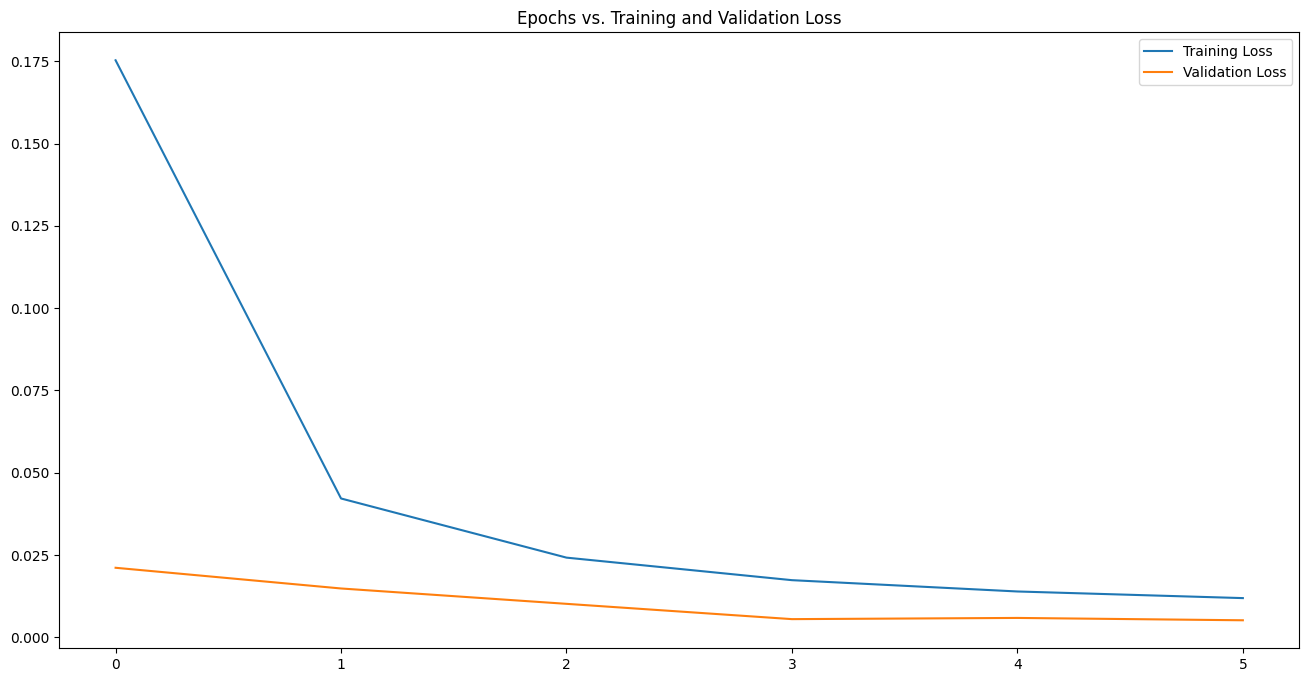

In [48]:
plot_model_loss(history)

In [49]:
forecast = model.predict(X_test)
# transforecast = y_sc.inverse_transform(forecast)

228/228 [==============================] - 7s 23ms/step


In [50]:
y_test_inv = np.squeeze(y_test)

In [51]:
calculate_evaluation_metrics(y_test_inv[:,0], forecast[:,0])

/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'RMSE': 0.109, 'MAPE': inf, 'NMAE': 0.356}

In [52]:
# Estrai le date e i dati corrispondenti
dates_train = dataset_input.index[:int(len(dataset_input) * train_size)]
dates_test = dataset_input.index[int(len(dataset_input) * train_size):]

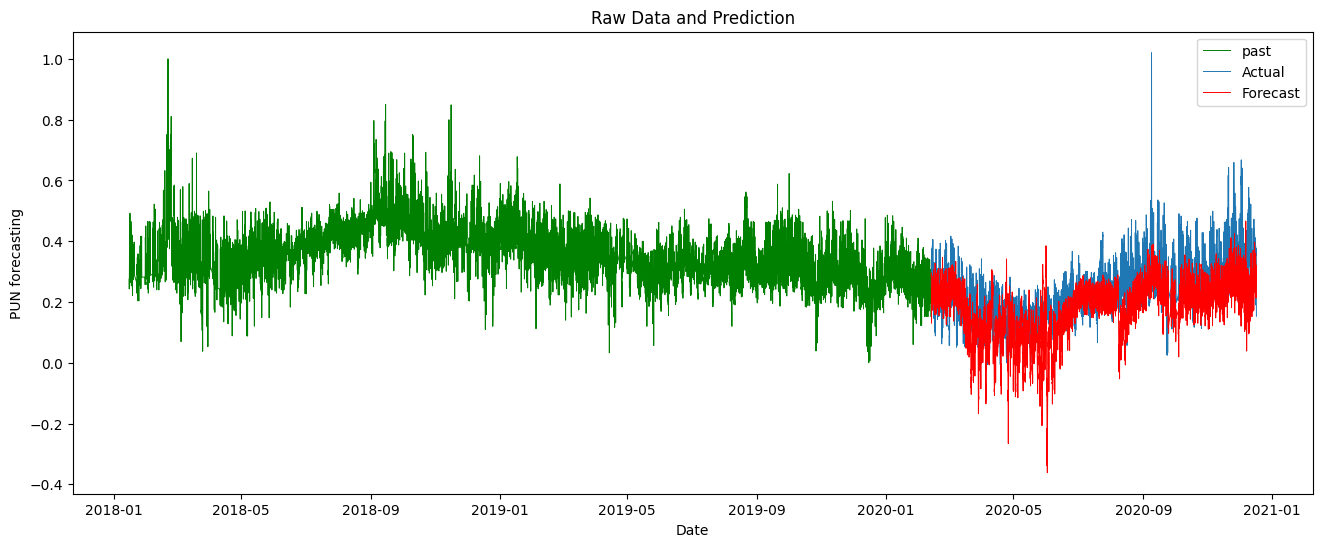

In [53]:
# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(dates_train, y_train[:,0], linewidth=0.7, color='g', label='past')
plt.plot(dates_test[:len(y_test)], y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(dates_test[:len(y_test)], forecast[:,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

#### Error on rows instead of columns 

In [21]:
errors = calculate_rmse_errors(y_test_inv, forecast)

In [22]:
# Ottieni il timestamp per le righe di test
test_timestamps = dataset_input.iloc[-y_test_inv.shape[0]:].index

# Converti l'indice in oggetti datetime
test_timestamps = pd.to_datetime(test_timestamps)

Errore relativo a 302 giorni, a partire da mezzanotte


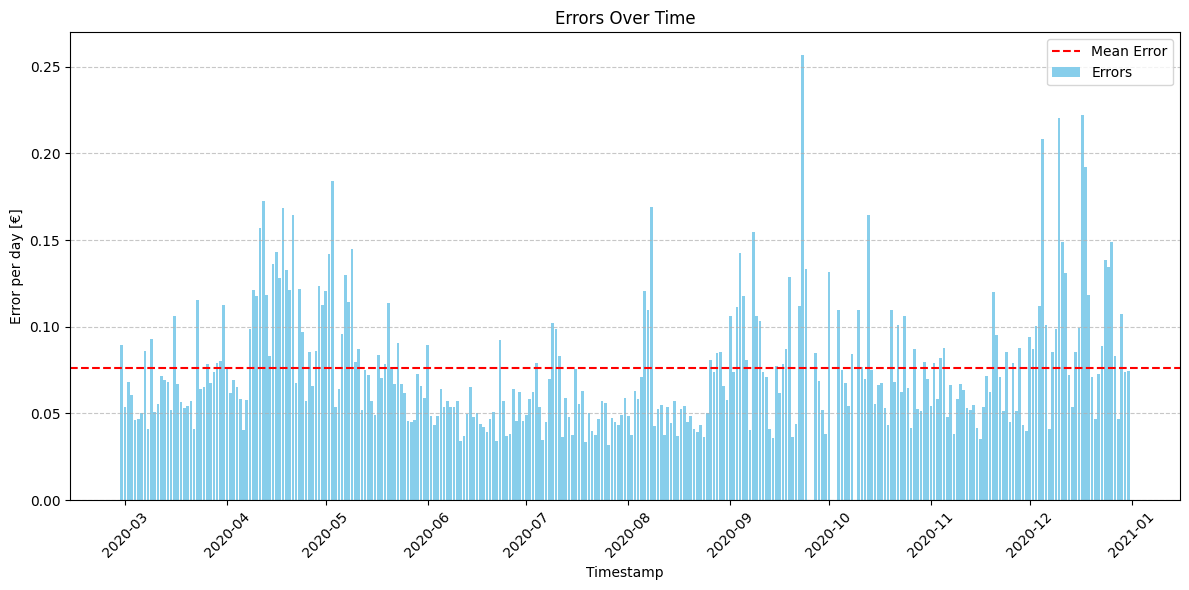

Media degli errori relativi alla mezzanotte: 0.07614431101820299


In [23]:
midnight_errors, midnight_timestamps = filter_errors_at_midnight(errors, test_timestamps)

mean_midnight_error = np.mean(midnight_errors)

visualize_errors_with_timestamps(midnight_errors, midnight_timestamps, mean_midnight_error)


print("Media degli errori relativi alla mezzanotte:", mean_midnight_error)

#### Errors on columns

/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning

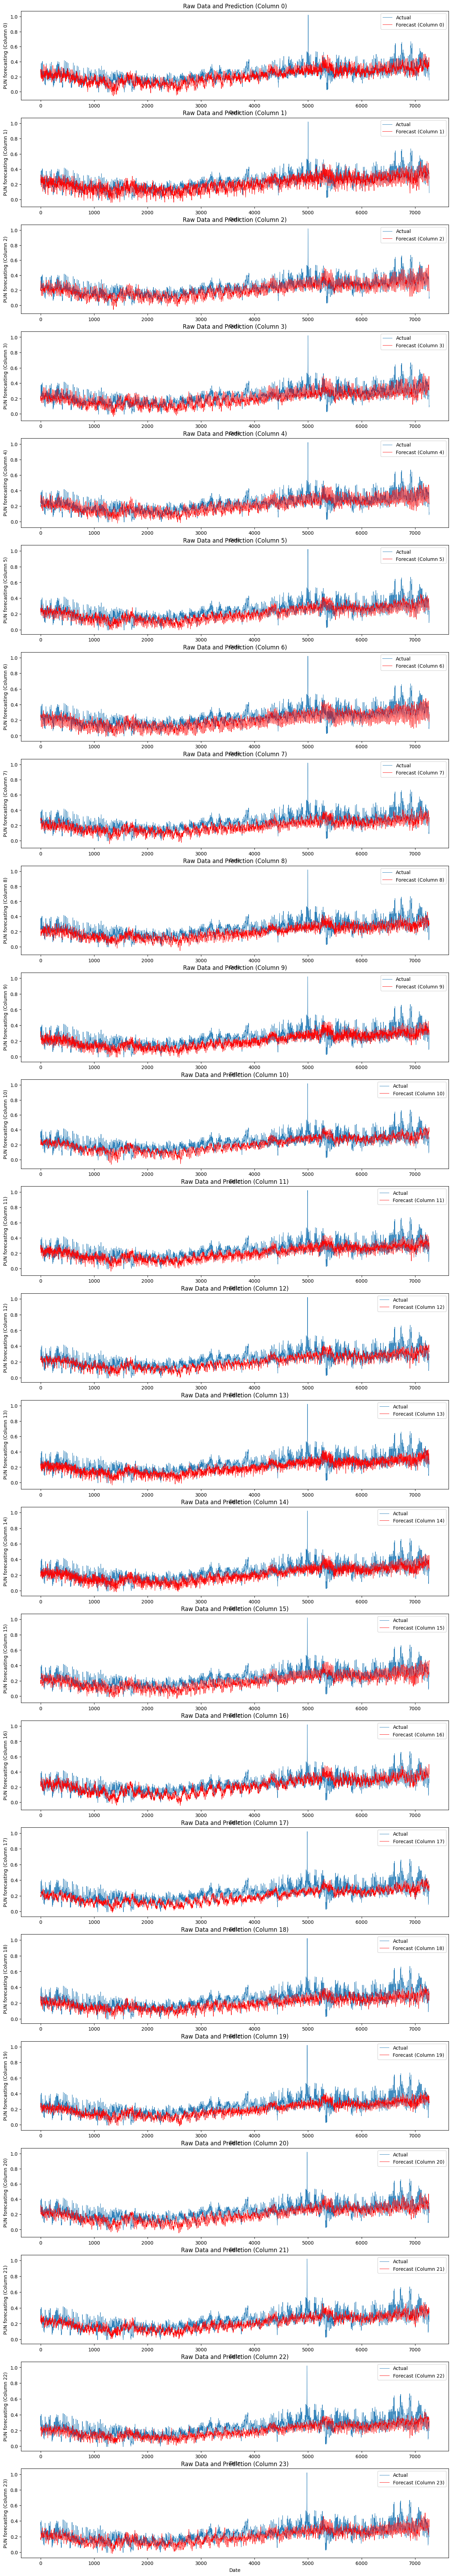

In [42]:
uni_table = evaluate_and_plot_timeseries(y_test_inv, forecast, show_plot=True)

Min NMAE: 0.244 for Column: 0.0
Min RMSE: 0.074 for Column: 0.0
Min MAPE: inf for Column: 0.0
Mean NMAE: 0.2791666666666666
Mean RMSE: 0.08458333333333333
Mean MAPE: inf


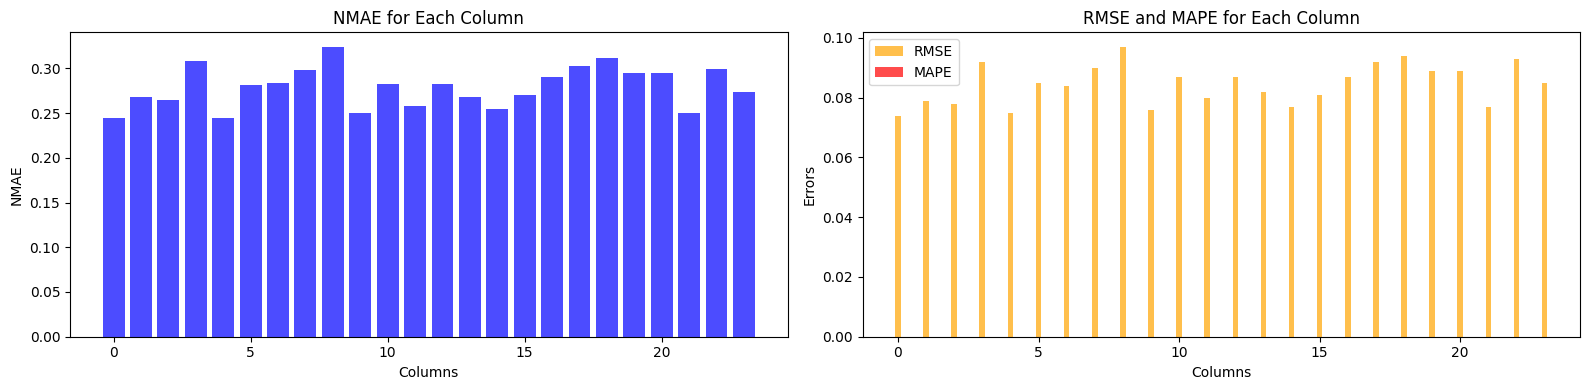

In [43]:
plot_error_metrics_barchart(uni_table)

### Simply Encoder - Decoder

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.


In [94]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                        0, train_index, past_history,
                                        target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    train_index, test_index, past_history,
                                    target_size, step=step, single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


X_train shape: (17791, 24, 1)
y_train shape: (17791, 24)
X_test shape: (7555, 24, 1)
y_test shape: (7555, 24)


In [83]:
# E1D1
n_features = X_train.shape[2]

encoder_inputs = tf.keras.layers.Input(shape=(past_history, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_l1(encoder_inputs)
encoder_states1 = [state_h1, state_c1]

decoder_inputs = tf.keras.layers.RepeatVector(target_size)(encoder_outputs1)

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(target_size))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

In [84]:
# E2D2
encoder_inputs = tf.keras.layers.Input(shape=(past_history, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_l1(encoder_inputs)
encoder_states1 = [state_h1, state_c1]

encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_l2(encoder_outputs1)
encoder_states2 = [state_h2, state_c2]

decoder_inputs = tf.keras.layers.RepeatVector(target_size)(encoder_outputs2)

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1, initial_state=encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(target_size))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs, decoder_outputs2)

In [85]:
# Modifica per aggiungere una dimensione per la lunghezza della sequenza temporale
y_train_ed = np.expand_dims(y_train, axis=-1)

In [89]:


model_e1d1.compile(optimizer='adam', loss='mean_squared_error')

history_e1d1 = model_e1d1.fit(X_train, y_train_ed, epochs=25,
                            validation_split=0.2, batch_size=32,
                            verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0002, restore_best_weights=True)])

model_e2d2.compile(optimizer='adam', loss='mean_squared_error')

history_e2d2 = model_e2d2.fit(X_train, y_train_ed, epochs=50,
                            validation_split=0.2, batch_size=32,
                            verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0002, restore_best_weights=True)])


Epoch 1/25
445/445 [==============================] - 13s 15ms/step - loss: 59.1899 - val_loss: 75.7686
Epoch 2/25
445/445 [==============================] - 6s 13ms/step - loss: 58.3558 - val_loss: 81.4249
Epoch 3/25
445/445 [==============================] - 6s 13ms/step - loss: 57.6671 - val_loss: 78.4049
Epoch 4/25
445/445 [==============================] - 6s 13ms/step - loss: 57.0216 - val_loss: 77.0568
Epoch 5/25
445/445 [==============================] - 6s 13ms/step - loss: 57.1541 - val_loss: 79.9392
Epoch 6/25
445/445 [==============================] - 6s 13ms/step - loss: 56.1059 - val_loss: 76.9825
Epoch 7/25
445/445 [==============================] - 6s 13ms/step - loss: 55.6492 - val_loss: 79.1049
Epoch 8/25
445/445 [==============================] - 5s 12ms/step - loss: 55.5739 - val_loss: 77.8639
Epoch 1/50
445/445 [==============================] - 22s 26ms/step - loss: 1655.5858 - val_loss: 231.1692
Epoch 2/50
445/445 [==============================] - 9s 20ms/step -

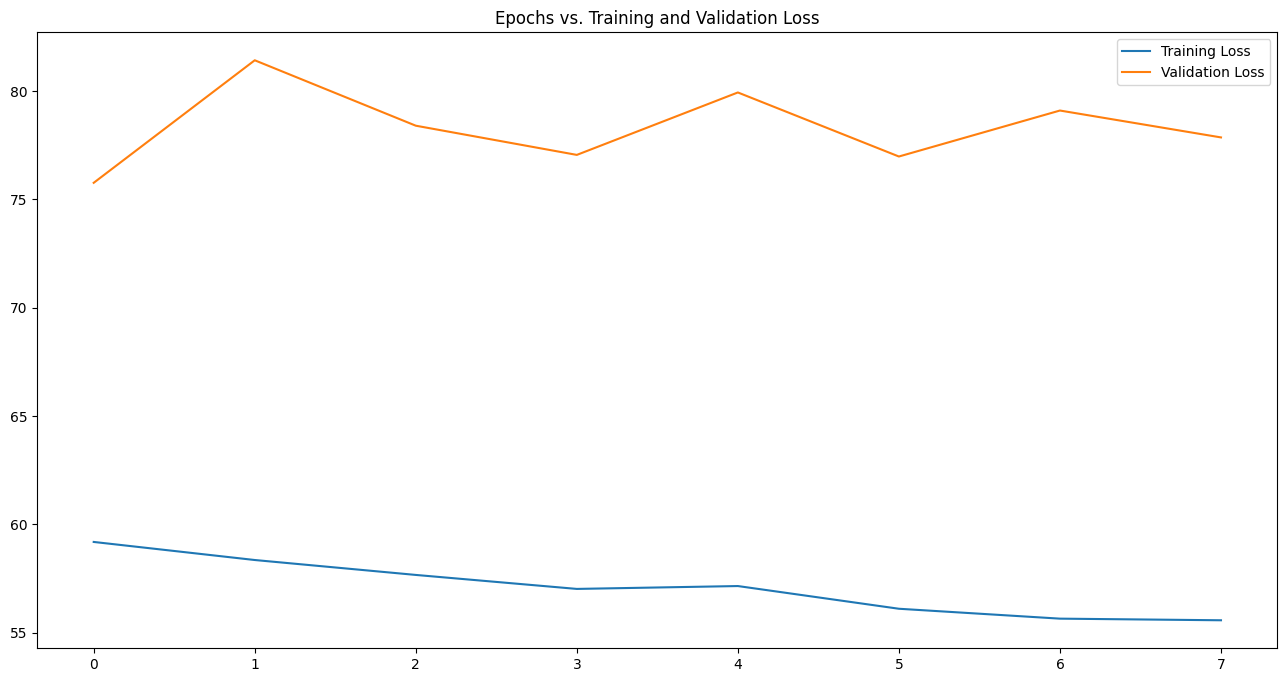

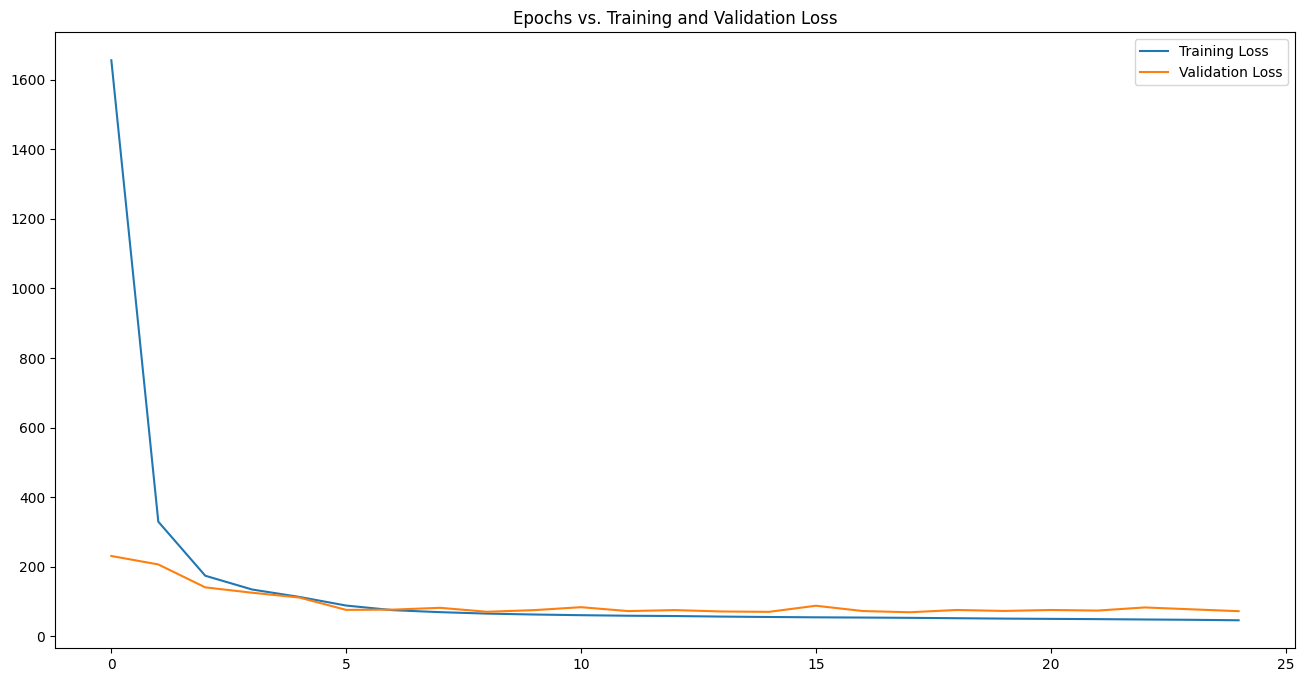

In [90]:
plot_model_loss(history_e1d1)
plot_model_loss(history_e2d2)

In [91]:
forecast_ed1 = model_e1d1.predict(X_test)
forecast_ed2 = model_e2d2.predict(X_test)

237/237 [==============================] - 4s 7ms/step


In [92]:
forecast_ed1[:,:,0]=y_sc.inverse_transform(forecast_ed1[:,:,0])
forecast_ed2[:,:,0]=y_sc.inverse_transform(forecast_ed2[:,:,0])

# life hack: ctrl + d per selezionare tutte le occorrenze di un determinato carattere

/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/gperri-ext/master_thesis_tryout-2/models/evaluation_func.py:115: RuntimeWarning

Min NMAE: 165.825 for Column: 0.0
Min RMSE: 6625.183 for Column: 0.0
Min MAPE: inf for Column: 0.0
Mean NMAE: 194.17904166666668
Mean RMSE: 7544.9108750000005
Mean MAPE: inf


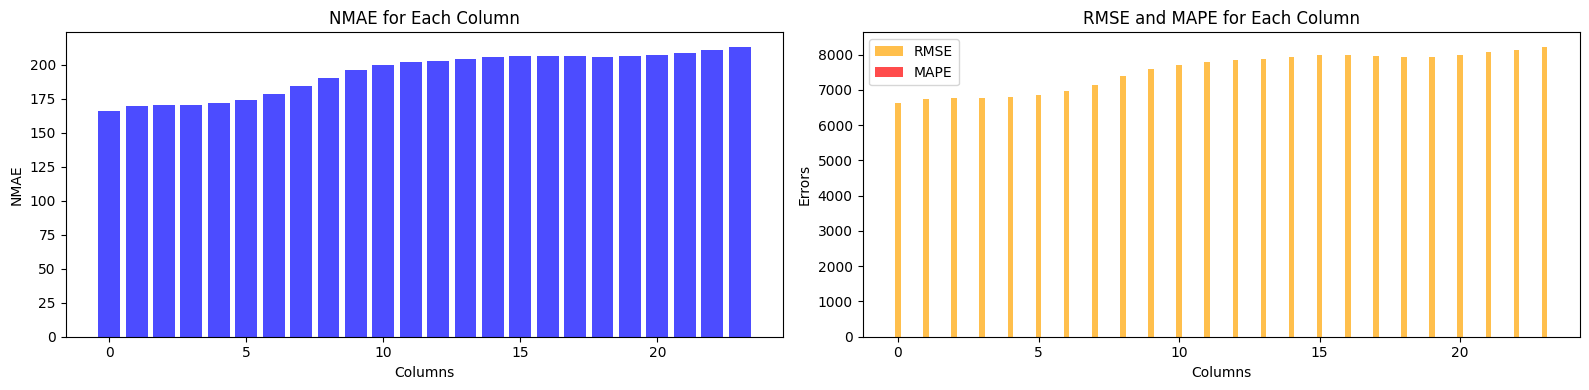

In [93]:
lstm2_table = evaluate_and_plot_timeseries(y_test_inv, forecast_ed1[:,:,0], show_plot=False)
plot_error_metrics_barchart(lstm2_table)